# Test DINOv2 feature extraction capabilibites on selected datasets

In [2]:
import torch
import torchvision
import faiss
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.decomposition import PCA
from torchvision import transforms

## Load CIFAR10 dataset

In [23]:
cifar_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=cifar_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=cifar_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


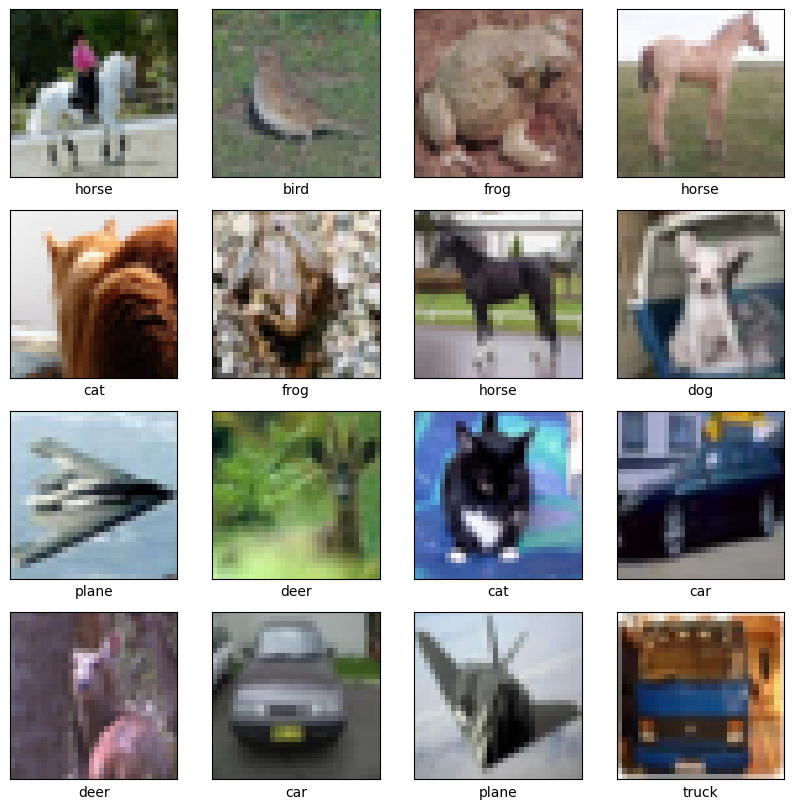

In [17]:
def show_images(imgs, labels, classes):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        img = imgs[i] / 2 + 0.5
        img = img.numpy().transpose(1, 2, 0)
        ax.imshow(img)
        ax.set_xlabel(classes[labels[i]])
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

show_images(images, labels, classes)

## Load DINOv2 model and prepare helper functions

In [21]:
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')

def dino_preprocess(img):
    transform = transforms.Compose([
        transforms.Resize(520),
        transforms.CenterCrop(518),                         
        transforms.Normalize(mean=0.5, std=0.2)
    ])

    return transform(img)

def dino_extract_features(model, img):
    patch_size = dinov2.patch_size # patchsize=14

    patch_h = 520//patch_size
    patch_w = 520//patch_size

    feat_dim = 1024

    with torch.no_grad():
        features_dict = dinov2.forward_features(img.unsqueeze(0))
        features = features_dict['x_norm_patchtokens']

    total_features = features.reshape(1 * patch_h * patch_w, feat_dim)

    return total_features, patch_h, patch_w

def dino_features_to_img(img_features, patch_h, patch_w):
    pca = PCA(n_components=3)
    pca.fit(img_features)
    pca_features = pca.transform(img_features)

    pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                        (pca_features[:, 0].max() - pca_features[:, 0].min())

    return pca_features[:, 0].reshape(patch_h, patch_w)

Using cache found in /Users/michal/.cache/torch/hub/facebookresearch_dinov2_main


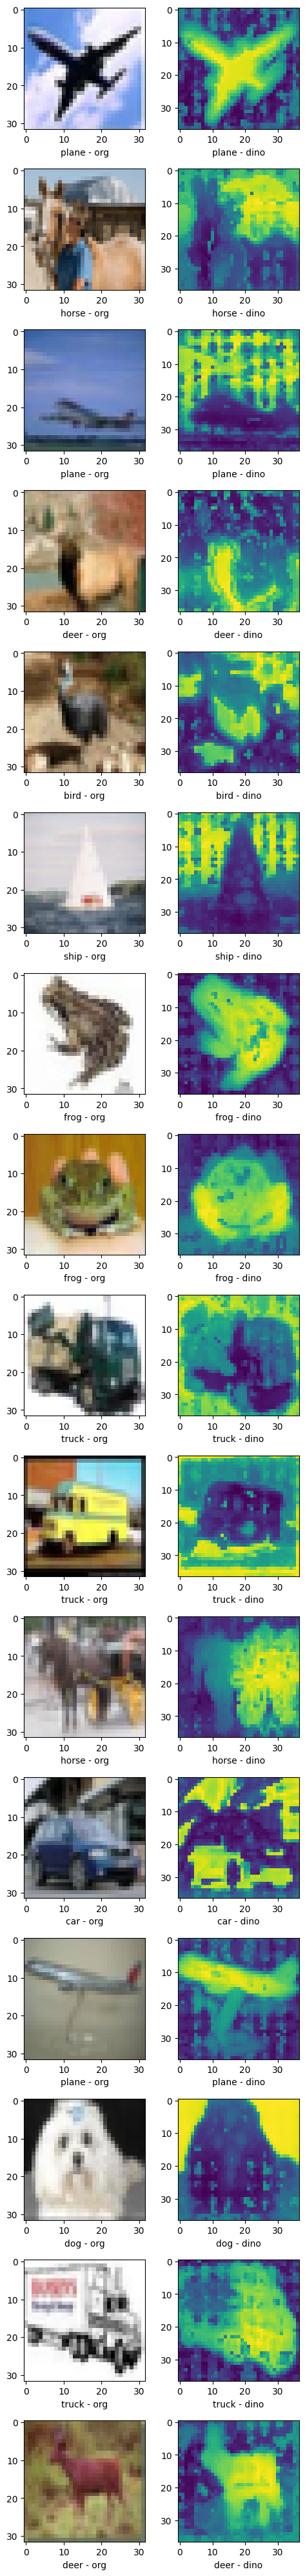

In [39]:
images, labels = next(dataiter)

fig, axes = plt.subplots(16, 2, figsize=(5, 40))

for i, (img, label) in enumerate(zip(images, labels)):
    preprocessed_img = dino_preprocess(img)
    features, patch_h, patch_w = dino_extract_features(dinov2, preprocessed_img)
    img_features = dino_features_to_img(features, patch_h, patch_w)

    img = img / 2 + 0.5
    img = img.numpy().transpose(1, 2, 0)
    axes[i, 0].imshow(img)
    axes[i, 1].imshow(img_features)

    axes[i, 0].set_xlabel(f'{classes[labels[i]]} - org')
    axes[i, 1].set_xlabel(f'{classes[labels[i]]} - dino')

plt.tight_layout()
plt.show()